## 0. Setup
Load your SQL magics.

In [1]:
%reload_ext sql
%config SqlMagic.autocommit=False
%config SqlMagic.autolimit=0
%config SqlMagic.autopandas=True
%config SqlMagic.displaylimit=200

In [2]:
%sql trino://localhost:9090/cuebiq/

'Connected: @cuebiq/'

<a id='hierarchy'></a>
## 1. Catalogs, schemas, tables
Users have access to two catalogs that can be seen here: 
> **Catalogs are the top-level entity within Spectus Data Clean Room**

In [3]:
%%sql
show catalogs

 * trino://localhost:9090/cuebiq/
Done.


,Catalog
0,cuebiq
1,dedicated
2,delta
3,internal_cuebiq
4,internal_delta
5,system


#### The schema with the data for you is **ds_data_for_complexity**

In [5]:
schema = 'ds_data_for_complexity'

In [6]:
q = f"""show tables from dedicated.{schema}"""

# 2. Importing and/or installing libraries

In [8]:
!pip install seaborn -q -q
!pip install geohash2 -q -q

In [9]:
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
from scipy import stats
from keplergl import KeplerGl

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter

import geohash2
import json

In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

# 3. Tables exploration

In [11]:
stops_table_name = f'dedicated.{schema}.selected_stops'
device_location_table_name = f'dedicated.{schema}.device_location_and_stops_subsampled_v2'

In [12]:
df_stops[df_stops.overlapping_stop==1].shape

NameError: name 'df_stops' is not defined

### 3.1 stops table

In [14]:
query = f"""
select *
from {stops_table_name}
order by lineage_id, zoned_datetime
limit 1000
"""
df_stops = %sql $query

 * trino://localhost:9090/cuebiq/
Done.


#### 3.1.1 Trends

#### Where they are

In [16]:
query = f"""
select 
    event_date,
    count (distinct lineage_id) as cnt_lineage,
    count (distinct stop_id) as cnt_stops
from {stops_table_name}
group by event_date
order by event_date
"""
df_stop_trend = %sql $query
df_stop_trend['event_date'] = pd.to_datetime(df_stop_trend['event_date'], format='%Y%m%d')

 * trino://localhost:9090/cuebiq/
Done.


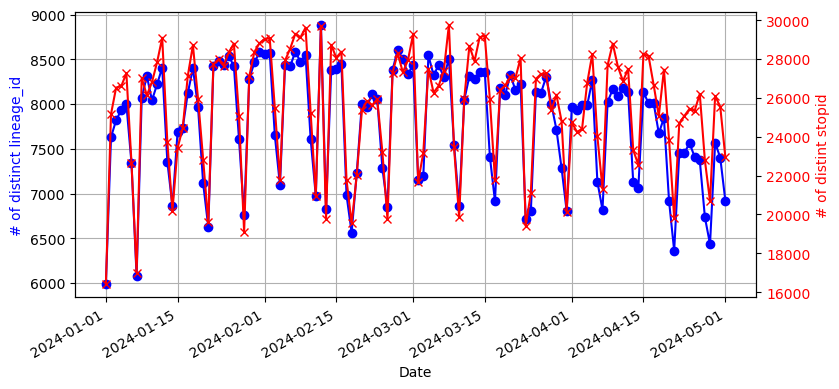

In [17]:
fig, ax1 = plt.subplots(figsize=(8.5, 4))

ax1.plot(df_stop_trend.event_date, df_stop_trend.cnt_lineage, label='cnt_lineage', marker='o', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('# of distinct lineage_id', color='b')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate() 
ax1.grid()

ax2 = ax1.twinx()
ax2.plot(df_stop_trend.event_date, df_stop_trend.cnt_stops, label='cnt_stops', marker='x', color='r')
ax2.set_ylabel('# of distint stopid', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.tight_layout()

plt.show()

In [18]:
map_ = KeplerGl(height=400)
map_.add_data(df_stops, name='Stops')
map_

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Stops': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2…

### 3.2 device location table

In [19]:
query = f"""
select *
from {device_location_table_name}
where event_date = 20240406
"""
df_dev_loc = %sql $query

 * trino://localhost:9090/cuebiq/
Done.


In [51]:
query = f"""
WITH distinct_stop AS (
    SELECT lineage_id,
           stop_dwell_time_minutes,
           event_date
    FROM {device_location_table_name}
    WHERE stop_id IS NOT NULL
    GROUP BY lineage_id, stop_dwell_time_minutes, event_date
) 

select event_date, 
    avg(stop_dwell_time_minutes) as avg_stop, 
    max(stop_dwell_time_minutes) as max_stop, 
    min(stop_dwell_time_minutes) as min_stop
from distinct_stop
group by event_date
order by event_date
"""

df_stop_per_day = %sql $query

 * trino://localhost:9090/cuebiq/
Done.


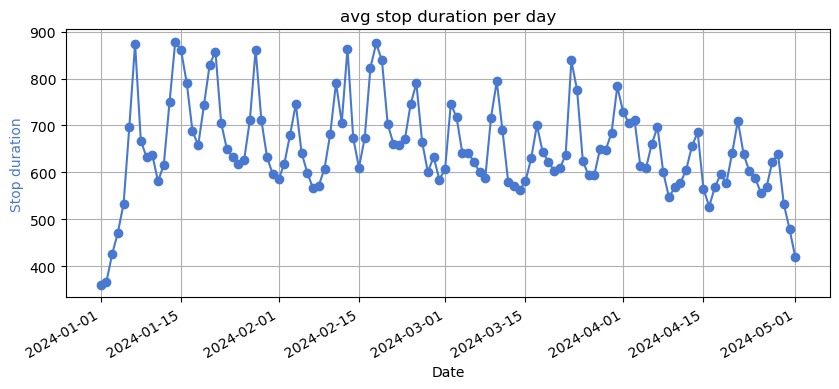

In [80]:
df_stop_per_day['event_date'] = pd.to_datetime(df_stop_per_day['event_date'], format='%Y%m%d')

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(8.5, 4))

# Plot the distinct_stops on the primary y-axis
#ax1.plot(df_stop_per_day.event_date, df_stop_per_day.max_stop, color='b')
#ax1.plot(df_stop_per_day.event_date, df_stop_per_day.min_stop, color='b')
ax1.plot(df_stop_per_day.event_date, df_stop_per_day.avg_stop, marker='o', color='b')

ax1.set_xlabel('Date')
ax1.set_ylabel('Stop duration', color='b')

# Set the date format on the x-axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

# Set the y-axis to plain style (remove scientific notation)
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax1.yaxis.get_major_formatter().set_scientific(False)
ax1.yaxis.get_major_formatter().set_useOffset(False)

# Add grid, title, and legends
ax1.grid()
plt.title('avg stop duration per day')
fig.tight_layout()
# Display the plot
plt.show()

In [67]:
query = f"""
WITH distinct_stop AS (
    SELECT lineage_id,
           stop_dwell_time_minutes,
           event_date
    FROM {device_location_table_name}
    WHERE stop_id IS NOT NULL
    GROUP BY lineage_id, stop_dwell_time_minutes, event_date
) 

select event_date, 
    stop_dwell_time_minutes
from distinct_stop
where event_date = 20240406
"""

df_stop_single_day = %sql $query

 * trino://localhost:9090/cuebiq/
Done.


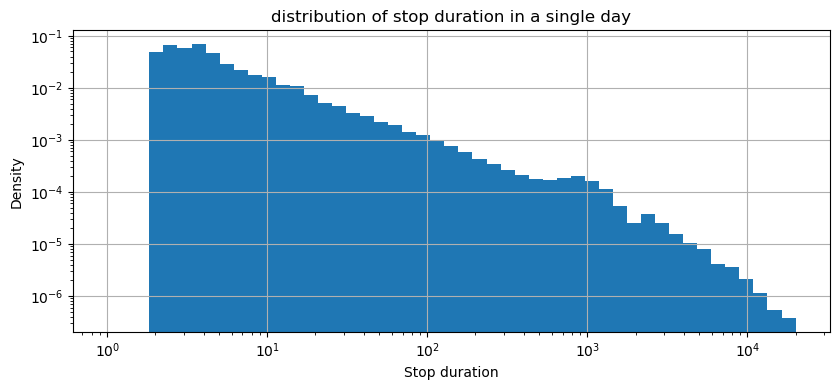

In [ ]:
df_stop_single_day['event_date'] = pd.to_datetime(df_stop_single_day['event_date'], format='%Y%m%d')

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(8.5, 4))

# Plot the distinct_stops on the primary y-axis
#ax1.plot(df_stop_per_day.event_date, df_stop_per_day.max_stop, color='b')
#ax1.plot(df_stop_per_day.event_date, df_stop_per_day.min_stop, color='b')
#ax1.plot(df_stop_per_day.event_date, df_stop_per_day.avg_stop, marker='o', color='b')
ax1.hist(df_stop_single_day.stop_dwell_time_minutes, density=True, bins=np.logspace(np.log10(1),np.log10(20000), 50))

ax1.set_xlabel('Stop duration')
ax1.set_ylabel('Density')

# Set the y-axis to plain style (remove scientific notation)
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax1.yaxis.get_major_formatter().set_scientific(False)
ax1.yaxis.get_major_formatter().set_useOffset(False)

# Add grid, title, and legends
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid()
plt.title('distribution of stop duration in a single day')
fig.tight_layout()
# Display the plot
plt.show()

#### 3.2.4 number of devices per day

 * trino://localhost:9090/cuebiq/
Done.


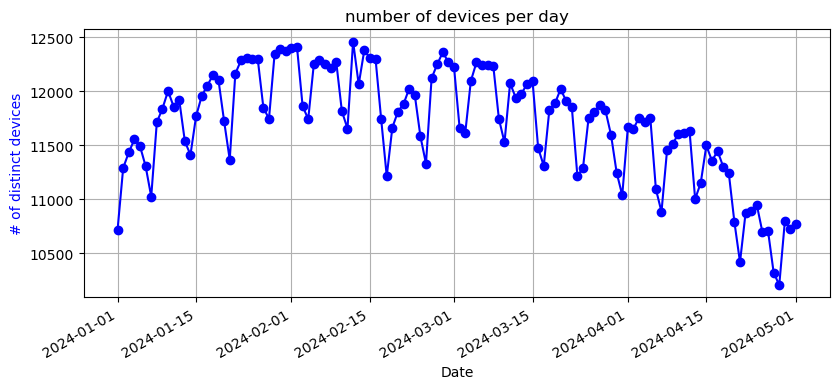

In [24]:
query = f"""
select event_date, 
       count(distinct lineage_id) as number_of_lineage_id
from {device_location_table_name}
group by event_date
order by event_date
"""
df_dev_per_day = %sql $query

df_dev_per_day['event_date'] = pd.to_datetime(df_dev_per_day['event_date'], format='%Y%m%d')
# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(8.5, 4))

# Plot the distinct_stops on the primary y-axis
ax1.plot(df_dev_per_day.event_date, df_dev_per_day.number_of_lineage_id, marker='o', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('# of distinct devices', color='b')

# Set the date format on the x-axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

# Set the y-axis to plain style (remove scientific notation)
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax1.yaxis.get_major_formatter().set_scientific(False)
ax1.yaxis.get_major_formatter().set_useOffset(False)

# Add grid, title, and legends
ax1.grid()
plt.title('number of devices per day')
fig.tight_layout()
# Display the plot
plt.show()

#### 3.2.5 number of pings per day

 * trino://localhost:9090/cuebiq/
Done.


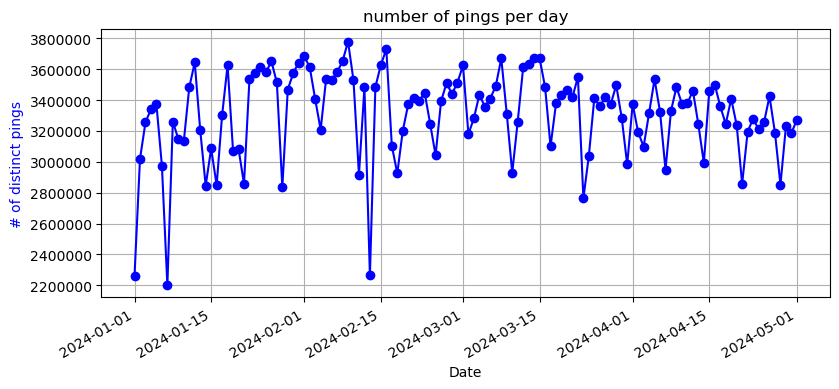

In [25]:
query = f"""
select event_date, 
       count(*) as number_of_ping
from {device_location_table_name}
group by event_date
order by event_date
"""
df_pings_per_day = %sql $query

df_pings_per_day['event_date'] = pd.to_datetime(df_pings_per_day['event_date'], format='%Y%m%d')
# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(8.5, 4))

# Plot the distinct_stops on the primary y-axis
ax1.plot(df_pings_per_day.event_date, df_pings_per_day.number_of_ping, marker='o', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('# of distinct pings', color='b')

# Set the date format on the x-axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

# Set the y-axis to plain style (remove scientific notation)
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
ax1.yaxis.get_major_formatter().set_scientific(False)
ax1.yaxis.get_major_formatter().set_useOffset(False)

# Add grid, title, and legends
ax1.grid()
plt.title('number of pings per day')
fig.tight_layout()
# Display the plot
plt.show()

In [26]:
query = f"""
with ping_per_device as(
select event_date, 
       lineage_id,
       count(*) as number_of_pings
from {device_location_table_name}
group by event_date, lineage_id
)

select event_date,
       avg(number_of_pings) AS mean,
       stddev(number_of_pings) AS std
from ping_per_device
group by event_date
order by event_date
"""
df_pings_per_day = %sql $query

 * trino://localhost:9090/cuebiq/
Done.


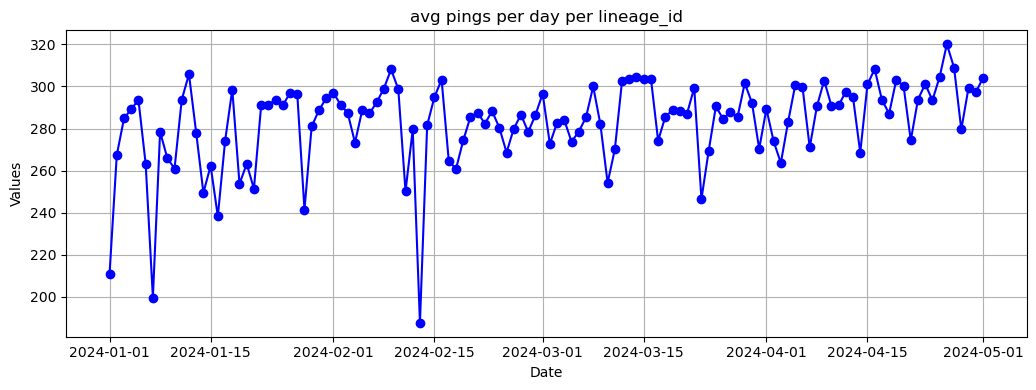

In [27]:
df_pings_per_day['event_date'] = pd.to_datetime(df_pings_per_day['event_date'], format='%Y%m%d')

plt.figure(figsize=(10.5, 4))

plt.plot(df_pings_per_day['event_date'], df_pings_per_day['mean'], marker='o', color='b')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('avg pings per day per lineage_id')

plt.grid(True)
plt.tight_layout()
plt.show()

#### 3.2.6 stop subsampling per day

 * trino://localhost:9090/cuebiq/
Done.


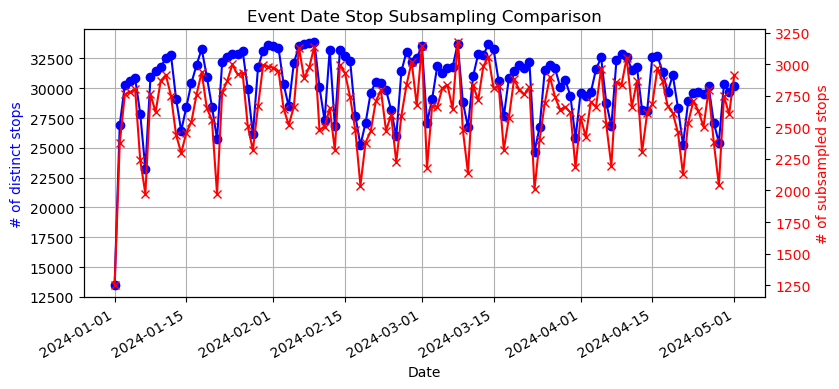

In [28]:
query = f"""
with total_stops as(
    select event_date, 
           count (distinct(stop_id)) as cnt_total_stops
    from {device_location_table_name}
    where subsampled is not null
    group by event_date
),

subsampled_stops AS (
    select event_date, 
           count (distinct(stop_id)) as cnt_subsampled_stops
    from {device_location_table_name}
    where subsampled = 1
    group by event_date
)

select t.cnt_total_stops,
       s.cnt_subsampled_stops,
       100. * s.cnt_subsampled_stops/t.cnt_total_stops,
       t.event_date
from total_stops t
join subsampled_stops s
    on t.event_date = s.event_date
order by event_date
"""

df_subsampling_per_day = %sql $query

df_subsampling_per_day['event_date'] = pd.to_datetime(df_subsampling_per_day['event_date'], format='%Y%m%d')
# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(8.5, 4))

# Plot the distinct_stops on the primary y-axis
ax1.plot(df_subsampling_per_day.event_date, 
         df_subsampling_per_day.cnt_total_stops, label='cnt_total_stops', marker='o', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('# of distinct stops', color='b')
# Set the date format on the x-axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate() 
ax1.grid()
# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(df_subsampling_per_day.event_date, 
         df_subsampling_per_day.cnt_subsampled_stops, label='cnt_subsampled_stops', marker='x', color='r')
ax2.set_ylabel('# of subsampled stops', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add title and legends
plt.title('Event Date Stop Subsampling Comparison')
fig.tight_layout()

# Display the plot
plt.show()

### 3.2.7 what does the stop class represent

In [29]:
def geohash_to_geojson(geohash):
    # Decode the geohash to get the bounding box
    lat, lon, lat_err, lon_err = geohash2.decode_exactly(geohash)
    lat_min = lat - lat_err
    lat_max = lat + lat_err
    lon_min = lon - lon_err
    lon_max = lon + lon_err

    # Create the GeoJSON polygon
    polygon = {
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates": [[
                [lon_min, lat_min],
                [lon_min, lat_max],
                [lon_max, lat_max],
                [lon_max, lat_min],
                [lon_min, lat_min]
            ]]
        },
        "properties": {
            "geohash": geohash
        }
    }
    return polygon

In [30]:
query = f"""
select  stop_class,
        substr(stop_geohash, 1, length(stop_geohash) - 3) AS geohash_level_6,
        count (distinct stop_id) as cnt_stops
from {device_location_table_name}
where stop_id is not null
group by 1,2
"""
df_stop_classes = %sql $query
df_stop_classes['geojson'] = df_stop_classes['geohash_level_6'].apply(geohash_to_geojson)

 * trino://localhost:9090/cuebiq/
Done.


In [31]:
config = {'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': '5xahcq',
     'type': 'geojson',
     'config': {'dataId': 'Stop class 1',
      'label': 'Stop class 1',
      'color': [255, 254, 230],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'geojson': 'geojson'},
      'isVisible': True,
      'visConfig': {'opacity': 0.25,
       'strokeOpacity': 0.8,
       'thickness': 0.5,
       'strokeColor': [255, 153, 31],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 10,
       'sizeRange': [0, 10],
       'radiusRange': [0, 50],
       'heightRange': [0, 500],
       'elevationScale': 5,
       'enableElevationZoomFactor': True,
       'stroked': False,
       'filled': True,
       'enable3d': False,
       'wireframe': False},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear',
      'heightField': None,
      'heightScale': 'linear',
      'radiusField': None,
      'radiusScale': 'linear'}},
    {'id': '1qi0vge',
     'type': 'geojson',
     'config': {'dataId': 'Stop class 2',
      'label': 'Stop class 2',
      'color': [255, 223, 153],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'geojson': 'geojson'},
      'isVisible': True,
      'visConfig': {'opacity': 0.56,
       'strokeOpacity': 0.8,
       'thickness': 0.5,
       'strokeColor': [34, 63, 154],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 10,
       'sizeRange': [0, 10],
       'radiusRange': [0, 50],
       'heightRange': [0, 500],
       'elevationScale': 5,
       'enableElevationZoomFactor': True,
       'stroked': False,
       'filled': True,
       'enable3d': False,
       'wireframe': False},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear',
      'heightField': None,
      'heightScale': 'linear',
      'radiusField': None,
      'radiusScale': 'linear'}},
    {'id': 'fwnj55',
     'type': 'geojson',
     'config': {'dataId': 'Stop class 3',
      'label': 'Stop class 3',
      'color': [245, 113, 65],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'geojson': 'geojson'},
      'isVisible': True,
      'visConfig': {'opacity': 0.8,
       'strokeOpacity': 0.8,
       'thickness': 0.5,
       'strokeColor': [18, 92, 119],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 10,
       'sizeRange': [0, 10],
       'radiusRange': [0, 50],
       'heightRange': [0, 500],
       'elevationScale': 5,
       'enableElevationZoomFactor': True,
       'stroked': False,
       'filled': True,
       'enable3d': False,
       'wireframe': False},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear',
      'heightField': None,
      'heightScale': 'linear',
      'radiusField': None,
      'radiusScale': 'linear'}},
    {'id': 'q04b8p',
     'type': 'geojson',
     'config': {'dataId': 'Stop class 4',
      'label': 'Stop class 4',
      'color': [218, 0, 0],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'geojson': 'geojson'},
      'isVisible': True,
      'visConfig': {'opacity': 0.8,
       'strokeOpacity': 0.8,
       'thickness': 0.5,
       'strokeColor': [119, 110, 87],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 10,
       'sizeRange': [0, 10],
       'radiusRange': [0, 50],
       'heightRange': [0, 500],
       'elevationScale': 5,
       'enableElevationZoomFactor': True,
       'stroked': False,
       'filled': True,
       'enable3d': False,
       'wireframe': False},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear',
      'heightField': None,
      'heightScale': 'linear',
      'radiusField': None,
      'radiusScale': 'linear'}}],
   'interactionConfig': {'tooltip': {'fieldsToShow': {'Stop class 1': [{'name': 'stop_class',
        'format': None},
       {'name': 'geohash_level_6', 'format': None}],
      'Stop class 2': [{'name': 'stop_class', 'format': None},
       {'name': 'geohash_level_6', 'format': None}],
      'Stop class 3': [{'name': 'stop_class', 'format': None},
       {'name': 'geohash_level_6', 'format': None}],
      'Stop class 4': [{'name': 'stop_class', 'format': None},
       {'name': 'geohash_level_6', 'format': None}]},
     'compareMode': False,
     'compareType': 'absolute',
     'enabled': True},
    'brush': {'size': 0.5, 'enabled': False},
    'geocoder': {'enabled': False},
    'coordinate': {'enabled': False}},
   'layerBlending': 'normal',
   'splitMaps': [],
   'animationConfig': {'currentTime': None, 'speed': 1}},
  'mapState': {'bearing': 0,
   'dragRotate': False,
   'latitude': 40.25417718880347,
   'longitude': -74.18454392785402,
   'pitch': 0,
   'zoom': 6.065762806417463,
   'isSplit': False},
  'mapStyle': {'styleType': 'dark',
   'topLayerGroups': {},
   'visibleLayerGroups': {'label': True,
    'road': True,
    'border': False,
    'building': True,
    'water': True,
    'land': True,
    '3d building': False},
   'threeDBuildingColor': [9.665468314072013,
    17.18305478057247,
    31.1442867897876],
   'mapStyles': {}}}}

In [32]:
map_towrite = KeplerGl(height=400, 
                       config=config)
map_towrite.add_data(df_stop_classes[df_stop_classes.stop_class==1], name='Stop class 1')
map_towrite.add_data(df_stop_classes[df_stop_classes.stop_class==2], name='Stop class 2')
map_towrite.add_data(df_stop_classes[df_stop_classes.stop_class==3], name='Stop class 3')
map_towrite.add_data(df_stop_classes[df_stop_classes.stop_class==4], name='Stop class 4')
map_towrite

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '5xahcq', 'type': '…

 * trino://localhost:9090/cuebiq/
Done.


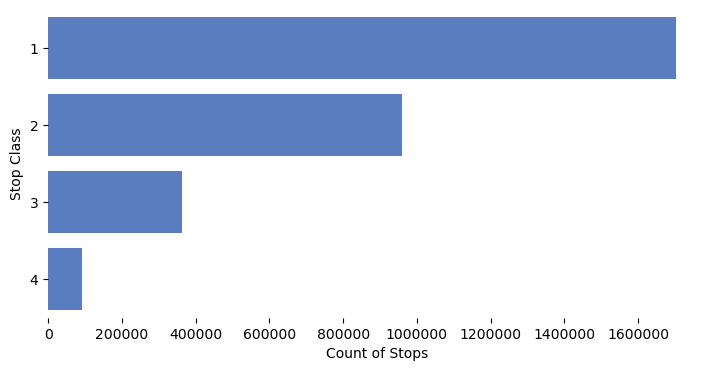

In [33]:
query = f"""
select stop_class,
       count (distinct stop_id) as cnt_stops
from {device_location_table_name}
where stop_id is not null
group by stop_class
"""
df_stop_classes = %sql $query
df_stop_classes.sort_values('stop_class', inplace=True)

fig, ax = plt.subplots(figsize=(8.5, 4))
sns.set_color_codes("muted")
sns.barplot(data=df_stop_classes, y='stop_class', x='cnt_stops', orient='h', color="b", ax=ax)
sns.despine(left=True, bottom=True)

ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax.xaxis.get_major_formatter().set_scientific(False)

plt.xlabel('Count of Stops')
plt.ylabel('Stop Class')

plt.show()

### 3.3 Example of a trajectory

In [34]:
query = f"""
select *
from {device_location_table_name}
where event_date = 20240406
and lineage_id = 9223372028664353817
"""
df_dev_loc = %sql $query

 * trino://localhost:9090/cuebiq/
Done.


In [35]:
df_dev_loc_stops = df_dev_loc[(~df_dev_loc.stop_id.isna()) 
                             &(df_dev_loc.subsampled == 0)]

df_dev_loc_stops_sub = df_dev_loc[(~df_dev_loc.stop_id.isna()) 
                             &(df_dev_loc.subsampled == 1)]

df_dev_loc_ = df_dev_loc[(df_dev_loc.stop_id.isna())]

In [36]:
config = {'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': 'crk0zv',
     'type': 'point',
     'config': {'dataId': 'stops points',
      'label': 'stops points',
      'color': [255, 254, 230],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'lat', 'lng': 'lng', 'altitude': None},
      'isVisible': True,
      'visConfig': {'radius': 6,
       'fixedRadius': False,
       'opacity': 0.5,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'vv0kny',
     'type': 'point',
     'config': {'dataId': 'stops points subsampled',
      'label': 'subsampled stops',
      'color': [218, 0, 0],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'lat', 'lng': 'lng', 'altitude': None},
      'isVisible': True,
      'visConfig': {'radius': 15,
       'fixedRadius': False,
       'opacity': 0.5,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'y8dl8rc',
     'type': 'point',
     'config': {'dataId': 'normal points',
      'label': 'normal trajectory',
      'color': [246, 209, 138],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'lat', 'lng': 'lng', 'altitude': None},
      'isVisible': True,
      'visConfig': {'radius': 4,
       'fixedRadius': False,
       'opacity': 0.5,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'ColorBrewer YlGnBu-8',
        'type': 'sequential',
        'category': 'ColorBrewer',
        'colors': ['#ffffd9',
         '#edf8b1',
         '#c7e9b4',
         '#7fcdbb',
         '#41b6c4',
         '#1d91c0',
         '#225ea8',
         '#0c2c84']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'event_timestamp',
       'type': 'timestamp'},
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}}],
   'interactionConfig': {'tooltip': {'fieldsToShow': {'stops points': [{'name': 'data_provider',
        'format': None},
       {'name': 'id_type', 'format': None},
       {'name': 'lineage_id', 'format': None},
       {'name': 'event_timestamp', 'format': None},
       {'name': 'event_zoned_datetime', 'format': None}],
      'stops points subsampled': [{'name': 'data_provider', 'format': None},
       {'name': 'id_type', 'format': None},
       {'name': 'lineage_id', 'format': None},
       {'name': 'event_timestamp', 'format': None},
       {'name': 'event_zoned_datetime', 'format': None}],
      'normal points': [{'name': 'data_provider', 'format': None},
       {'name': 'id_type', 'format': None},
       {'name': 'lineage_id', 'format': None},
       {'name': 'event_timestamp', 'format': None},
       {'name': 'event_zoned_datetime', 'format': None}]},
     'compareMode': False,
     'compareType': 'absolute',
     'enabled': True},
    'brush': {'size': 0.5, 'enabled': False},
    'geocoder': {'enabled': False},
    'coordinate': {'enabled': False}},
   'layerBlending': 'normal',
   'splitMaps': [],
   'animationConfig': {'currentTime': None, 'speed': 1}},
  'mapState': {'bearing': 0,
   'dragRotate': False,
   'latitude': 40.783059084439316,
   'longitude': -73.4173824806252,
   'pitch': 0,
   'zoom': 7.3547620510790015,
   'isSplit': False},
  'mapStyle': {'styleType': 'dark',
   'topLayerGroups': {},
   'visibleLayerGroups': {'label': True,
    'road': True,
    'border': False,
    'building': True,
    'water': True,
    'land': True,
    '3d building': False},
   'threeDBuildingColor': [9.665468314072013,
    17.18305478057247,
    31.1442867897876],
   'mapStyles': {}}}}

In [37]:
map_towrite = KeplerGl(height=400, 
                       config=config)
map_towrite.add_data(df_dev_loc_stops, name='stops points')
map_towrite.add_data(df_dev_loc_stops_sub, name='stops points subsampled')
map_towrite.add_data(df_dev_loc_, name='normal points')
map_towrite

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/srv/conda/envs/notebook/lib/python3.9/site-packages/jupyter_client/session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'crk0zv', 'type': '…